In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from huggingface_hub import HfApi
from transformers import AutoTokenizer,AutoModelForSequenceClassification,Trainer,TrainingArguments


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


import os
import torch
os.environ["WANDB_DISABLED"] = "true"


In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# **Loading & Understanding The Dataset**

In [ ]:
train=pd.read_csv('/content/drive/MyDrive/Sentiment140/train_data.csv')
test=pd.read_csv('/content/drive/MyDrive/Sentiment140/test_data.csv')

In [ ]:
# Get the first 35000 rows
first_5000 = train.iloc[:50000]

# Get the last 35000 rows
last_5000 = train.iloc[-50000:]

# Concatenate the first and last 35000 rows
train = pd.concat([first_5000, last_5000])


In [ ]:
train.head()

,sentence,sentiment
0,awww that s a bummer you shoulda got david car...,0
1,is upset that he can t update his facebook by ...,0
2,i dived many times for the ball managed to sav...,0
3,my whole body feels itchy and like its on fire,0
4,no it s not behaving at all i m mad why am i h...,0


In [ ]:
print(f"shape of training data {train.shape}")
print(f"shape of testing data {test.shape}")

shape of training data (100000, 2)
shape of testing data (359, 2)


In [ ]:
train.info() # no missing values

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0 to 1523974
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentence   100000 non-null  object
 1   sentiment  100000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


In [ ]:
test.info() # no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359 entries, 0 to 358
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   359 non-null    object
 1   sentiment  359 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.7+ KB


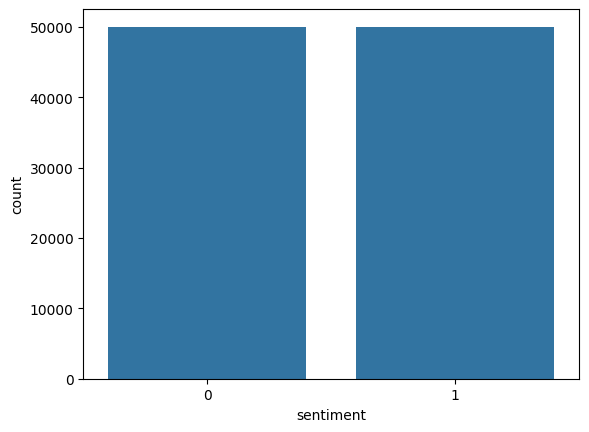

In [ ]:
# sentiment class is balanced
sns.countplot(x="sentiment",data=train)
plt.show()

In [ ]:
import re

def clean_text(text):
    # Check if text is a string before applying regex
    if isinstance(text, str):
        text = re.sub(r'http\S+', '', text)            # remove URLs
        text = re.sub(r'@\w+', '', text)               # remove mentions
        text = re.sub(r'#\w+', '', text)               # remove hashtags
        text = re.sub(r'[^\w\s]', '', text)            # remove punctuation
        text = re.sub(r'\s+', ' ', text).strip()       # remove extra spaces
        return text.lower()
    else:
        # Handle non-string inputs (e.g., integers)
        return str(text)  # Convert to string or handle as needed

train['sentence'] = train['sentence'].apply(clean_text)
test['sentence'] = test['sentence'].apply(clean_text)

In [ ]:
# Split the data into train and eval sets (70% train, 30% eval)
traindf, evaldf = train_test_split(train, shuffle=True, test_size=0.3, random_state=2001,stratify=train["sentiment"])

# Reset index after splitting and drop the old index
traindf.reset_index(drop=True, inplace=True)
evaldf.reset_index(drop=True, inplace=True)

# Check the shapes of the resulting datasets
traindf.shape, evaldf.shape


((70000, 2), (30000, 2))

# **Fine Tuning**

## **Model**

In [ ]:
#model_id="huawei-noah/TinyBERT_General_4L_312D"
#model_id = "bert-base-uncased"
model_id = "vinai/bertweet-base"


In [ ]:
model=AutoModelForSequenceClassification.from_pretrained(model_id,num_labels=2)
model=model.to(device)
model

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

## **Tokenizer**

In [ ]:
tokenizer=AutoTokenizer.from_pretrained(model_id)
tokenizer

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


BertweetTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	64000: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

## **Evaluation**

In [ ]:
# The input is pred, which is a dict containing both predictions and label_ids.

# The shape of pred.predictions (logits) is (batch_size, num_labels).
# It contains the predicted raw scores (logits) for each class in the classification task.
# Example shape: (64, 2) for a batch of 64 samples and 2 possible labels.

# The shape of pred.label_ids (true labels) is (batch_size).
# It contains the true labels for each sample in the batch.
# Example shape: (64,) for a batch of 64 samples.

# Using argmax(-1) reduces the logits to predicted class labels by selecting the index of the highest score.
# The shape of preds after argmax(-1) is (batch_size), which matches the shape of pred.label_ids.
"""(
def compute_metrics(pred):
    # Convert logits to predicted class labels using argmax(-1)
    predictions = pred.predictions.argmax(-1)

    # Extract the true labels
    true_labels = pred.label_ids

    # Return accuracy score comparing predicted labels and true labels
    return {"accuracy": accuracy_score(true_labels, predictions)}
)"""
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


## **Trainer**

In [ ]:
training_args = TrainingArguments(
    output_dir="./model_results",
    eval_strategy="epoch",
    num_train_epochs=15,  # Avoid overfitting beyond this
    learning_rate=1e-5,  # Fine-tuned LR
    lr_scheduler_type="linear",  # Prevents drastic changes
    adam_beta2=0.98,  # Helps stabilize training
    logging_steps=50,
    weight_decay=0.01,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    warmup_ratio=0.2,
    save_total_limit=2,
    save_strategy="epoch",
    load_best_model_at_end=True,
    gradient_accumulation_steps=2,
    fp16=True,
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


# **Train The Model**

## **Tokenize Dataset**

In [ ]:
from datasets import Dataset
# Rename the columns first
traindf = traindf.rename(columns={"sentiment": "labels"})
evaldf = evaldf.rename(columns={"sentiment": "labels"})

trainds = Dataset.from_pandas(traindf)
evalds = Dataset.from_pandas(evaldf)

trainds

Dataset({
    features: ['sentence', 'labels'],
    num_rows: 70000
})

In [ ]:
def tokenization(batch):
    return tokenizer(batch["sentence"], padding="max_length", truncation=True, max_length=128)  # Adjust max_length if needed

In [ ]:
encoded_train = trainds.map(tokenization, batched=True)
encoded_eval = evalds.map(tokenization, batched=True)
encoded_eval

Map:   0%|          | 0/70000 [00:00<?, ? examples/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Dataset({
    features: ['sentence', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 30000
})

## **Train**

In [ ]:
"""trainer = Trainer(  # Corrected variable name
    model=model,
    args=training_args,
    train_dataset=encoded_train,
    eval_dataset=encoded_eval,
    compute_metrics=compute_metrics  # Ensure this is defined properly
)"""
# Add this to your imports
from transformers import Trainer, TrainingArguments

# Re-initialize the Trainer with your model and arguments
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train,
    eval_dataset=encoded_eval,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.381400,0.360166,0.850767,0.851462,0.850767,0.850693
2,0.325100,0.336325,0.860667,0.861907,0.860667,0.860547
3,0.309200,0.323862,0.863467,0.863723,0.863467,0.863443
4,0.277300,0.333358,0.865033,0.865034,0.865033,0.865033
5,0.229500,0.377525,0.863200,0.863496,0.863200,0.863172
6,0.183500,0.404511,0.859167,0.859472,0.859167,0.859137
7,0.129200,0.467122,0.859667,0.860274,0.859667,0.859607
8,0.121000,0.508979,0.857933,0.857969,0.857933,0.857930
9,0.091800,0.563601,0.854300,0.855706,0.854300,0.854156
10,0.090400,0.612350,0.855967,0.856019,0.855967,0.855961


TrainOutput(global_step=16410, training_loss=0.16659170399345616, metrics={'train_runtime': 6988.2843, 'train_samples_per_second': 150.251, 'train_steps_per_second': 2.348, 'total_flos': 6.9066652032e+16, 'train_loss': 0.16659170399345616, 'epoch': 15.0})

In [ ]:
# Evaluate on validation set after training
eval_results = trainer.evaluate()
print("Validation Results:", eval_results)

Validation Results: {'eval_loss': 0.32386165857315063, 'eval_accuracy': 0.8634666666666667, 'eval_precision': 0.8637227339375406, 'eval_recall': 0.8634666666666667, 'eval_f1': 0.8634426319629706, 'eval_runtime': 47.5961, 'eval_samples_per_second': 630.304, 'eval_steps_per_second': 9.854, 'epoch': 15.0}
